# 1. Loading the dataset 

In [1]:
import kagglehub

kagglehub.dataset_download("utkarshsaxenadn/fruits-classification")

'/kaggle/input/fruits-classification'

The fruit classification dataset is a collection of images of various fruits used for the purpose of 
the training and testing computer vision models. The dataset includes five different types of fruit:


Apples

Bananas

Grapes

Mangoes

Strawberries


**The images in the dataset are of various shapes, sizes, and colors, and have been captured under different lighting conditions .**

# 2. Import Required Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch
import torchvision
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models



# 3. Data Preprocessing

**Define image transformations (resize, normalization, etc.)**

In [3]:
transform = transforms.Compose([
    transforms.Resize((256,256)),   # Resize the images to (256,256)
    transforms.ToTensor(),           # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


**Define dataset paths**

In [4]:
train_dir = '/kaggle/input/fruits-classification/Fruits Classification/train'
val_dir = '/kaggle/input/fruits-classification/Fruits Classification/valid'
test_dir = '/kaggle/input/fruits-classification/Fruits Classification/test'

##### Load datasets using ImageFolder and apply transformations

In [5]:
train_data= datasets.ImageFolder(root=train_dir, transform=transform)
val_data= datasets.ImageFolder(root=val_dir, transform=transform)
test_data= datasets.ImageFolder(root=test_dir, transform=transform)

#### Combine the datasets (training, validation, test)

In [6]:
full_dataset = torch.utils.data.ConcatDataset([train_data, val_data, test_data])
train_size = 7000
val_size = 2000
test_size = 1000

#### Split the full dataset into train, val, and test sets

In [7]:
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


 #### Create DataLoader instances for batching

In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 7000
Validation dataset size: 2000
Test dataset size: 1000


# 4. Data visualisation 

**Visualize some images from the dataset**

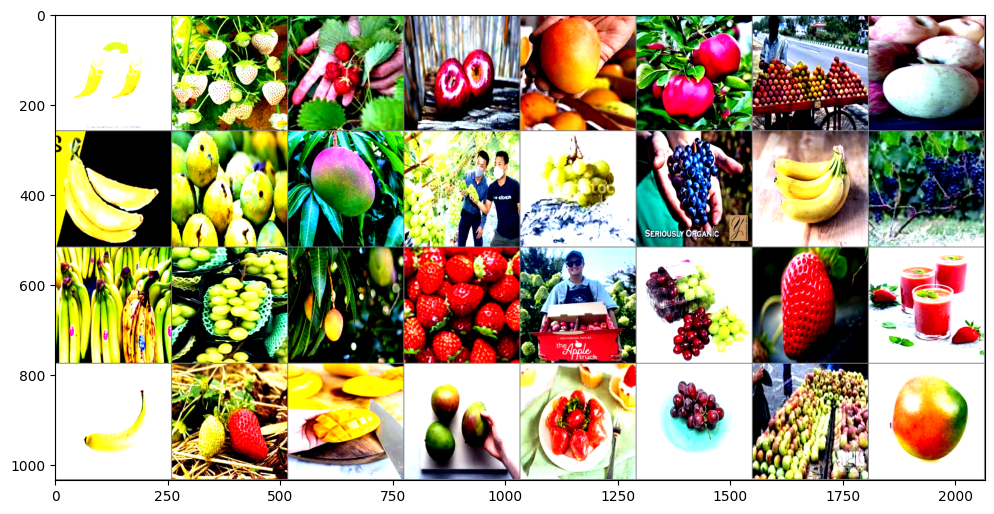

In [10]:
def imshow(img, size=(12, 12)):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()

    plt.figure(figsize=size)
    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training data
data_iter = iter(train_loader)
images, labels = next(data_iter)

imshow(torchvision.utils.make_grid(images), size=(12, 12))


# 5. Model Building

In [11]:
# Load a pre-trained ResNet model
model = models.resnet50(pretrained=True)

# Modify the last fully connected layer 
# to match the number of classes 
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(train_data.classes))
)

# Move model to GPU
device = torch.device("cuda")
model.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 182MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 6.  Define Loss Function and Optimizer

In [12]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#optimizer = optim.Adam(model.parameters(), lr=0.001)


# 7. Training Loop

In [13]:
num_epochs = 15
train_losses = []
val_losses = []
val_accuracy = []
train_accuracy = []
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagation
        optimizer.step()  # Optimize the weights

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get predicted labels
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
   
    
    train_loss= running_loss/len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")
    train_losses.append(train_loss)
    train_accuracy.append(100 * correct / total)



    
    # Evaluate on the validation set
    model.eval() 
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    
    val_loss=val_loss/len(val_loader)
    print(f"Validation Accuracy: {100 * correct / total:.2f}%")
    print(f"Validation Loss: {val_loss:.4f}")
    val_losses.append(val_loss)
    val_accuracy.append(100 * correct / total)


Epoch 1/15, Loss: 0.8233, Accuracy: 73.26%
Validation Accuracy: 91.90%
Validation Loss: 0.2683
Epoch 2/15, Loss: 0.2585, Accuracy: 91.96%
Validation Accuracy: 94.70%
Validation Loss: 0.1729
Epoch 3/15, Loss: 0.1553, Accuracy: 95.26%
Validation Accuracy: 94.65%
Validation Loss: 0.1524
Epoch 4/15, Loss: 0.0913, Accuracy: 97.19%
Validation Accuracy: 94.70%
Validation Loss: 0.1536
Epoch 5/15, Loss: 0.0586, Accuracy: 98.40%
Validation Accuracy: 94.90%
Validation Loss: 0.1498
Epoch 6/15, Loss: 0.0368, Accuracy: 99.04%
Validation Accuracy: 95.05%
Validation Loss: 0.1478
Epoch 7/15, Loss: 0.0246, Accuracy: 99.34%
Validation Accuracy: 95.35%
Validation Loss: 0.1513
Epoch 8/15, Loss: 0.0184, Accuracy: 99.56%
Validation Accuracy: 95.35%
Validation Loss: 0.1614
Epoch 9/15, Loss: 0.0181, Accuracy: 99.53%
Validation Accuracy: 95.55%
Validation Loss: 0.1566
Epoch 10/15, Loss: 0.0128, Accuracy: 99.67%
Validation Accuracy: 95.20%
Validation Loss: 0.1646
Epoch 11/15, Loss: 0.0129, Accuracy: 99.60%
Valid

# 8. Evaluate the Model on the Test Set

In [14]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

all_preds = []  # for Confusion 
all_labels = [] # Matrix

with torch.no_grad():  # No need to compute gradients during evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {test_loss/len(test_loader):.4f}")


Test Accuracy: 94.10%
Test Loss: 0.1917


# 9: Plotting Training & Validation Loss

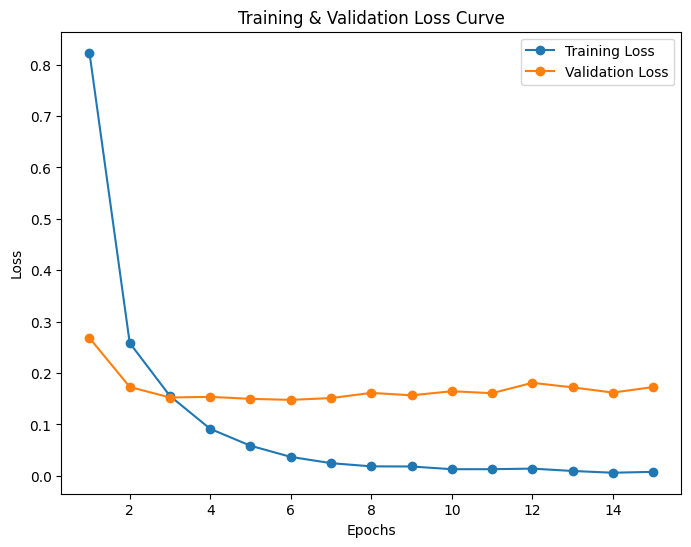

In [15]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Curve')
plt.legend()
plt.show()

# 10: Plotting Training & Validation Accuracy

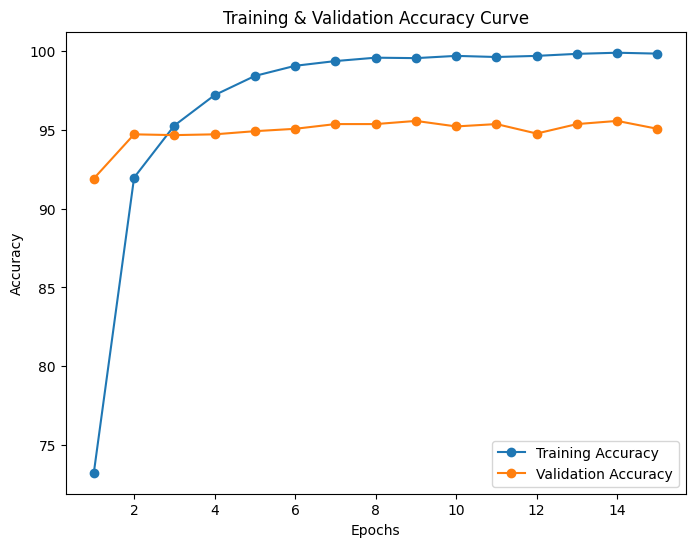

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs+1), train_accuracy, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs+1), val_accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy Curve')
plt.legend()
plt.show()

# 11. Confusion Matrix

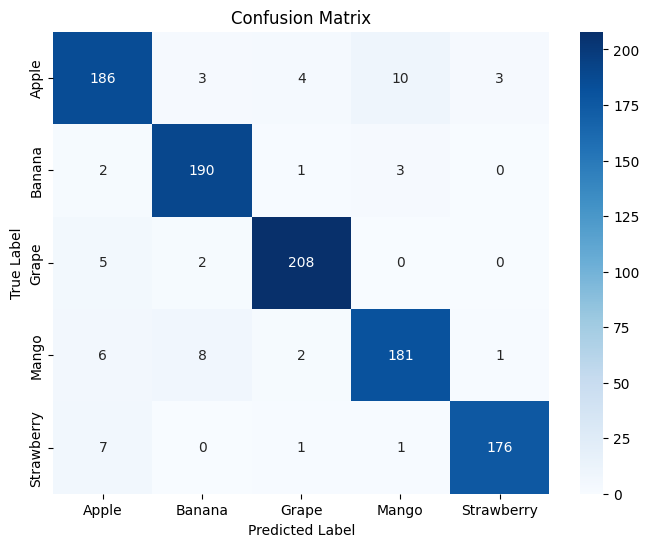

In [17]:
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()